In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import seaborn as sns
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
# Function to retrieve stock info
def get_stock_info(ticker_list,start_date,end_date,interval='1mo'):
    """
    Extract stock price data from Yahoo.Finance using a list of tickers
    :param ticker_list: A series/list of Tickets
    :param start_date: time period to start retrieving the data, e.g.'1900-01-01'
    :param end_date: time period to end retrieving the data, e.g.'1900-01-01'
    :param interval: time interval to retrieve the data. Valid formats: {number}m/h/d/wk/mo
    :return: a df with stock open, high, low, and close rpices, as well as trading volume and additional info
    """
    ticker_list = list(ticker_list)
    index_count = 0
    for stock in ticker_list:
        if index_count == 0:
            print(f'[i] Collecting data for {stock} has been started')
            ticker = yf.Ticker(f'{stock}')
            data = ticker.history(interval=interval,start=start_date,end=end_date)
            data['Company'] = f'{stock}'
            print(f'[+] data for {stock} has been collected')
            index_count += 1
        elif index_count != 0:
            print(f'[i] Collecting data for {stock} has been started')
            ticker = yf.Ticker(f'{stock}')
            data_2 = ticker.history(interval=interval,start=start_date,end=end_date)
            data_2['Company'] = f'{stock}' 
            data = pd.concat([data,data_2])
            print(f'[+] data for {stock} has been collected')
            if index_count == len(ticker_list):
                print('Info Data for all tickers has been collected')
    return data[['Company','Open','High','Low','Close','Volume','Dividends','Stock Splits']]

In [3]:
# Function to calculate the sharpe ratio
def sharpe_ratio(df):
    """
    Calculate the sharpe ratio for a given df
    :param df: a df for which the calculation is needed
    :return: a df with a calculated sharpe ratio
    """
    ust_10 = pd.read_csv(r'/Users/STUFF/Library/CloudStorage/Dropbox/Mac (2)/Desktop/513 Project/S&P500/MIQUBO/ust10.csv')
    company_list = []
    year_list = []
    return_y_array = []
    risk_free = []
    excess_return = []
    sector_list = []
    industry_list = []
    stdev_list = []
    
    for company in df['Company'].unique():
        for year in df['Year'].unique():
            # Calculate yearly return
            tmp_df = df.query(f'Company == "{company}" & Year == {year} & Month == 1').reset_index()
            try:
                p1 = tmp_df['Close'][0]
                tmp_df = df.query(f'Company == "{company}" & Year == {year} & Month == 12').reset_index()
            except:
                return_y = np.nan
            try:
                p2 = tmp_df['Close'][0]
                return_y = (p2-p1)/p1
            except:
                return_y = np.nan
            # Get risk-free rate
            tmp_df = ust_10.query(f'Year == {year} & Month == 1').reset_index()
            r = tmp_df['Close'][0]/100
            # Excess return
            er = return_y-r
            # Calcualte StDev
            try:
                tmp_df = df.query(f'Company == "{company}" & Year == {year}').reset_index()
                sd = tmp_df['mo_return'].std()
            except:
                sd = np.nan
            # Get Sector and Industry
            tmp_df = df.query(f'Company == "{company}"').reset_index()
            sector = tmp_df['GICS Sector'][0]
            industry = tmp_df['GICS Sub-Industry'][0]
            # Append values
            company_list.append(f'{company}')
            year_list.append(year)
            return_y_array.append(return_y)
            risk_free.append(r)
            sector_list.append(sector)
            industry_list.append(industry)
            excess_return.append(er)
            stdev_list.append(sd)
            
    df_f = pd.DataFrame({'Company':company_list,'year':year_list,'yearly_return':return_y_array,
                        'risk_free_r':risk_free,'excess_return':excess_return,'StDev_return':stdev_list,
                        'Sector':sector_list,'Industry': industry_list})
    df_f['StDev_excess_return'] = np.nan
    for company in df_f['Company'].unique():
        df_f['StDev_excess_return'] = np.where(df_f['Company'] == company,
                                 df_f.query(f'Company == "{company}"').loc[:,'excess_return'].std(),
                                 df_f['StDev_excess_return'])
    df_f['sharpe_ratio'] = df_f['excess_return']/df_f['StDev_excess_return']
    return df_f

In [4]:
# =============================================================================
# Data Extraction
# =============================================================================
# Selecting Dates to use
date_begin = input('Enter the beginning date for the analysis as a string, the formatting is YYYY-MM-DD without quotes:\n')
date_end = input('Enter the ending date for the analysis as a string, the formatting is YYYY-MM-DD without quotes:\n')
date_begin_n = int(date_begin.split('-')[0])
date_end_n = int(date_end.split('-')[0])

# Collecting a table from the Wikipedia Page about the S&P 500
wiki_url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
wiki_list = pd.read_html(wiki_url,header=0)
wiki_list = wiki_list[0]

# Creating a data set with companies from Wiki
sp500_companies = wiki_list[['Symbol','Security','GICS Sector','GICS Sub-Industry','Founded']].rename(columns={'Symbol': 'Company'})

# Using a parsing fuction to retrieve the stock data
raw_sp500_stock = get_stock_info(sp500_companies['Company'],date_begin,date_end)
raw_ust_10 = get_stock_info(['^TNX'],date_begin,date_end)
raw_sp500_index = get_stock_info(['^GSPC'],date_begin,date_end)

# Removing timezone from columns
df_process_list = [raw_sp500_stock,raw_ust_10,raw_sp500_index]
for df in df_process_list:
    # Add the Year, day and Month columns
    df['Year'] = pd.DatetimeIndex(df.index).year
    df['Month'] = pd.DatetimeIndex(df.index).month
    df['Day'] = pd.DatetimeIndex(df.index).day

# Removing DateTime Index
raw_sp500_stock = raw_sp500_stock[raw_sp500_stock['Day'] == 1].reset_index().drop('Date', axis = 1)
raw_ust_10 = raw_ust_10[raw_ust_10['Day'] == 1].reset_index().drop('Date', axis = 1)
raw_sp500_index = raw_sp500_index[raw_sp500_index['Day'] == 1].reset_index().drop('Date', axis = 1)

from pathlib import Path  
filepath = Path('/Users/STUFF/Library/CloudStorage/Dropbox/Mac (2)/Desktop/513 Project/S&P500/MIQUBO/output_2.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

[i] Collecting data for MMM has been started
[+] data for MMM has been collected
[i] Collecting data for AOS has been started
[+] data for AOS has been collected
[i] Collecting data for ABT has been started
[+] data for ABT has been collected
[i] Collecting data for ABBV has been started
[+] data for ABBV has been collected
[i] Collecting data for ACN has been started
[+] data for ACN has been collected
[i] Collecting data for ATVI has been started
[+] data for ATVI has been collected
[i] Collecting data for ADM has been started
[+] data for ADM has been collected
[i] Collecting data for ADBE has been started
[+] data for ADBE has been collected
[i] Collecting data for ADP has been started
[+] data for ADP has been collected
[i] Collecting data for AAP has been started
[+] data for AAP has been collected
[i] Collecting data for AES has been started
[+] data for AES has been collected
[i] Collecting data for AFL has been started
[+] data for AFL has been collected
[i] Collecting data fo

In [5]:
# =============================================================================
# Data Processing
# =============================================================================
# Add Sector and Industry columns
clean_sp500_stock = pd.merge(raw_sp500_stock,sp500_companies,on='Company',how='left')
clean_sp500_index = raw_sp500_index.copy()

# Calc montly returns
clean_sp500_stock['mo_return'] = np.nan
clean_sp500_index['mo_return'] = np.nan
df_process_list = [clean_sp500_stock,clean_sp500_index]
for df in df_process_list:
    for company in df['Company'].unique():
        for year in range(date_begin_n,date_end_n+1):
            for month in range(1,13):
                value_1 = df.query(f'Company == "{company}" & Year == {year} & Month == {month}').reset_index()
                value_2 = df.query(f'Company == "{company}" & Year == {year} & Month == {month-1}').reset_index()
                try: value_1,value_2 = value_1['Close'][0],value_2['Close'][0]
                except: 
                        value_1 = df.query(f'Company == "{company}" & Year == {year} & Month == {month}').reset_index()
                        value_2 = df.query(f'Company == "{company}" & Year == {year-1} & Month == 12').reset_index()
                        try: value_1,value_2 = value_1['Close'][0],value_2['Close'][0]
                        except: value_1,value_2 = np.nan,np.nan
                value_f = (value_1-value_2)/value_2
                df['mo_return'] = np.where((df['Company'] == company) &
                                           (df['Year'] == year) &
                                           (df['Month'] == month), value_f,
                                           (df['mo_return']))

# Add Sector and Industry to use the sharpe function
clean_sp500_index['GICS Sector'] = 'S&P500 Index'
clean_sp500_index['GICS Sub-Industry'] = 'S&P500 Index'

In [6]:
# Apply the function
yearly_returns_stocks = sharpe_ratio(clean_sp500_stock)
yearly_returns_index = sharpe_ratio(clean_sp500_index)

In [7]:
# Compare each Stock Performance with S&P index
clean_sp500_stock['perform_vs_sp'] = np.nan
for company in clean_sp500_stock['Company'].unique():
    for year in range(date_begin_n,date_end_n+1):
        for month in range(1,13):
            value = clean_sp500_stock.query(f'Company == "{company}" & Year == {year} & Month == {month}').reset_index()
            try: value = value['mo_return'][0]
            except: value = np.nan
            sp_value = clean_sp500_index.query(f'Year == {year} & Month == {month}').reset_index()
            try: sp_value = sp_value['mo_return'][0]
            except: sp_value = np.nan
            clean_sp500_stock['perform_vs_sp'] = np.where((clean_sp500_stock['Company'] == company) &
                                                          (clean_sp500_stock['Year'] == year) &
                                                          (clean_sp500_stock['Month'] == month), value-sp_value,
                                                          (clean_sp500_stock['perform_vs_sp']))

In [8]:
# Calculate % of time
clean_sp500_stock['perform_flag'] = np.where(clean_sp500_stock['perform_vs_sp'] > 0,1,0)
clean_sp500_stock['time_higher_sp'] = np.nan
for company in clean_sp500_stock['Company'].unique():
    for year in range(date_begin_n,date_end_n+1):
        tmp_df = clean_sp500_stock.query(f'Company == "{company}" & Year == {year}').reset_index()
        clean_sp500_stock['time_higher_sp'] = np.where((clean_sp500_stock['Company'] == company) & 
                                                       (clean_sp500_stock['Year'] == year),
                                                       tmp_df['perform_flag'].sum()/len(tmp_df),
                                                       clean_sp500_stock['time_higher_sp'])

/var/folders/my/3k6ljkkn2fxf0bmxsr7jkrf00000gp/T/ipykernel_18488/4124110358.py:9: RuntimeWarning: invalid value encountered in long_scalars
  tmp_df['perform_flag'].sum()/len(tmp_df),
/var/folders/my/3k6ljkkn2fxf0bmxsr7jkrf00000gp/T/ipykernel_18488/4124110358.py:9: RuntimeWarning: invalid value encountered in long_scalars
  tmp_df['perform_flag'].sum()/len(tmp_df),
/var/folders/my/3k6ljkkn2fxf0bmxsr7jkrf00000gp/T/ipykernel_18488/4124110358.py:9: RuntimeWarning: invalid value encountered in long_scalars
  tmp_df['perform_flag'].sum()/len(tmp_df),


In [9]:
# Calculating monthly returns
clean_sp500_stock['mo_return'] = np.nan
clean_sp500_index['mo_return'] = np.nan
df_process_list = [clean_sp500_stock,clean_sp500_index]
# Loop to calculate the values
# Take each df in the processing list
for df in df_process_list:
    # Take each unique company
    for company in df['Company'].unique():
        # For each unique company in each year
        for year in range(date_begin_n,date_end_n+1):
            # For each unique company in each year in each month
            for month in range(1,13):
                # Get dfs with those company, year, and month filters
                value_1 = df.query(f'Company == "{company}" & Year == {year} & Month == {month}').reset_index()
                value_2 = df.query(f'Company == "{company}" & Year == {year} & Month == {month-1}').reset_index()
                # Try to get the Close Price
                try: value_1,value_2 = value_1['Close'][0],value_2['Close'][0]
                # If that does not work
                except: 
                        # Look at the 12 month for the second value and the year before the current year
                        value_1 = df.query(f'Company == "{company}" & Year == {year} & Month == {month}').reset_index()
                        value_2 = df.query(f'Company == "{company}" & Year == {year-1} & Month == 12').reset_index()
                        # Try to retrieve the Close Price
                        try: value_1,value_2 = value_1['Close'][0],value_2['Close'][0]
                        # If that does not work, assign nans
                        except: value_1,value_2 = np.nan,np.nan
                # Calculate the return
                value_f = (value_1-value_2)/value_2
                # Put the return in the correct cell
                df['mo_return'] = np.where((df['Company'] == company) &
                                           (df['Year'] == year) &
                                           (df['Month'] == month), value_f,
                                           (df['mo_return']))

In [10]:
# =============================================================================
# EDA
# =============================================================================
# 1. Central Tendency & Disperssion analysis
# Create a summary table with sector agg
sum_table_sectors = yearly_returns_stocks.loc[:,['Sector','Industry','year','yearly_return','sharpe_ratio']].groupby(
    by=['Sector','Industry','year'],as_index=False).mean()

In [13]:
# Select Top 5 the most performing and underperforming Industries in each year
data = sum_table_sectors.loc[:,['year','Sector', 'sharpe_ratio']].sort_values(
    by=['year','sharpe_ratio'],ascending=[1,0])

df=pd.DataFrame(data)
df

,year,Sector,sharpe_ratio
306,2020,Materials,3.230272
249,2020,Industrials,2.301707
27,2020,Consumer Discretionary,2.243980
201,2020,Industrials,2.227832
213,2020,Industrials,2.180405
294,2020,Materials,2.018938
24,2020,Communication Services,1.765253
90,2020,Consumer Staples,1.762754
300,2020,Materials,1.727506
192,2020,Health Care,1.517557


In [14]:
from pathlib import Path  
filepath = Path('/Users/STUFF/Library/CloudStorage/Dropbox/Mac (2)/Desktop/513 Project/S&P500/MIQUBO/gics.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath)

In [15]:
# 3. Time performance vs S&P500 analysis
sum_table_time = clean_sp500_stock.loc[:,['Company','time_higher_sp','Year','GICS Sector']].groupby(
    by=['Company','Year','GICS Sector']).mean().sort_values(by=['Year'],
                                              ascending=[0])

<AxesSubplot:title={'center':'Sharpe Ratio for S&P500 companies per year'}, xlabel='year', ylabel='sharpe_ratio'>

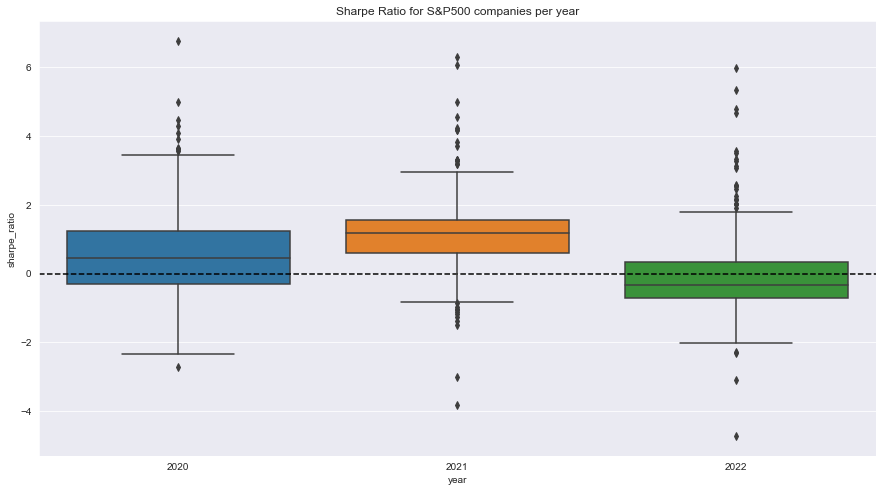

In [16]:
# =============================================================================
# Data Visualization
# =============================================================================
# Sharpe Ratio Boxplots for each year
sns.set_style('darkgrid')
plt.figure(figsize=(15,8))
plt.axhline(y=0, color='black', linestyle='--',ms=5)
plt.title('Sharpe Ratio for S&P500 companies per year')
plt.rcParams.update({'font.size': 10})
sns.boxplot(x='year',y='sharpe_ratio',data=yearly_returns_stocks)

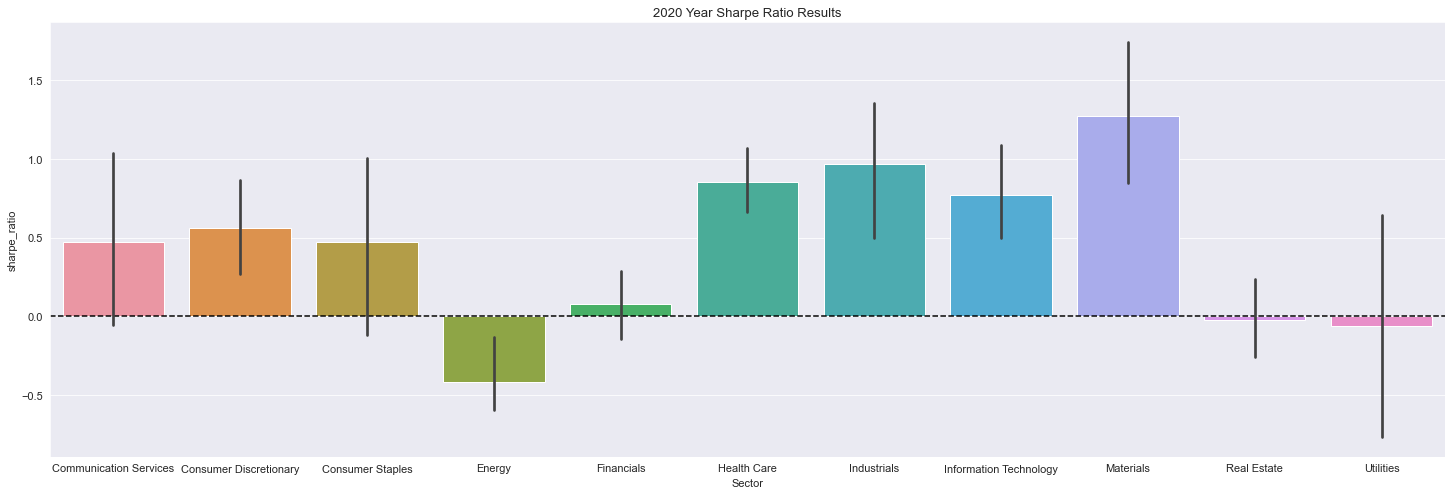

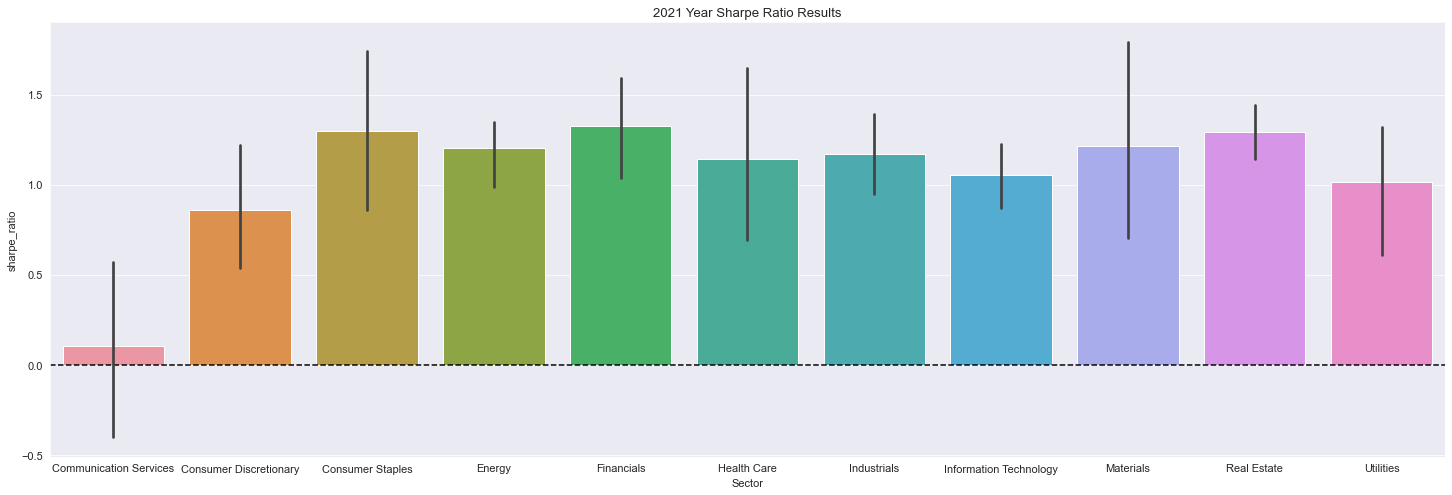

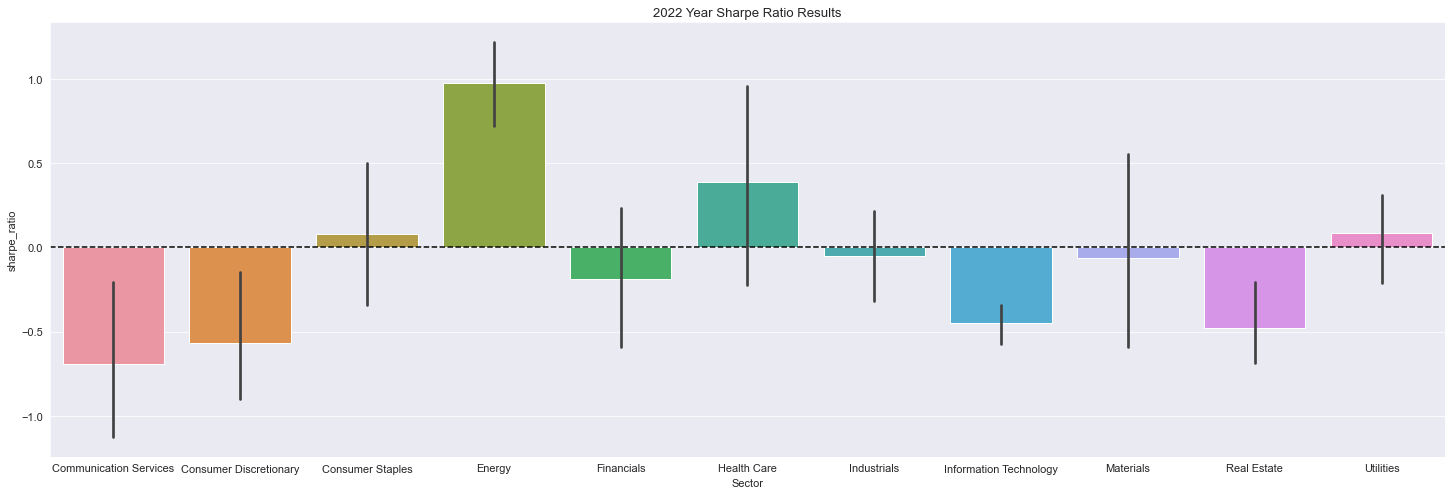

In [23]:
# Bar charts for each year  by sector
for year in range(date_begin_n,date_end_n+1):
    tmp_df = sum_table_sectors[sum_table_sectors['year'] == year]
    sns.set_style('darkgrid')
    plt.figure(figsize=(25,8))
    plt.axhline(y=0, color='black', linestyle='--',ms=5)
    plt.title(f'{year} Year Sharpe Ratio Results')
    plt.rcParams.update({'font.size': 11})
    sns.barplot(x='Sector',y='sharpe_ratio',data=tmp_df)
    plt.savefig('yr_sr.png')

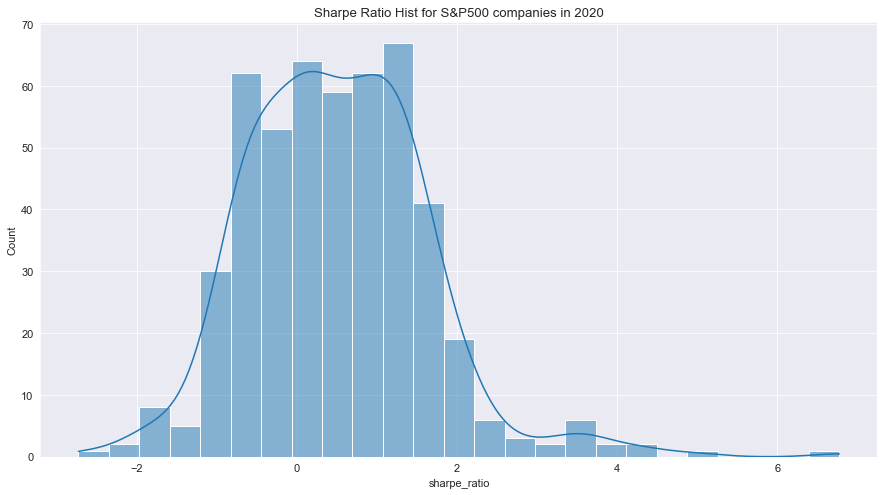

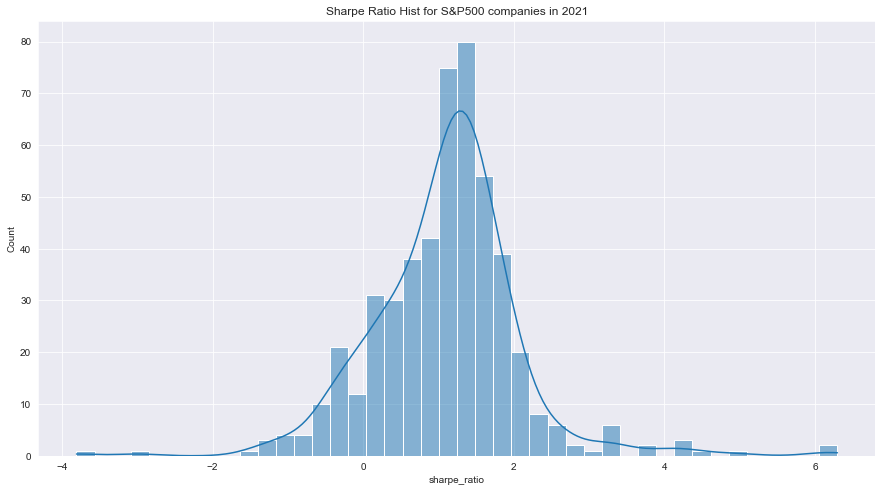

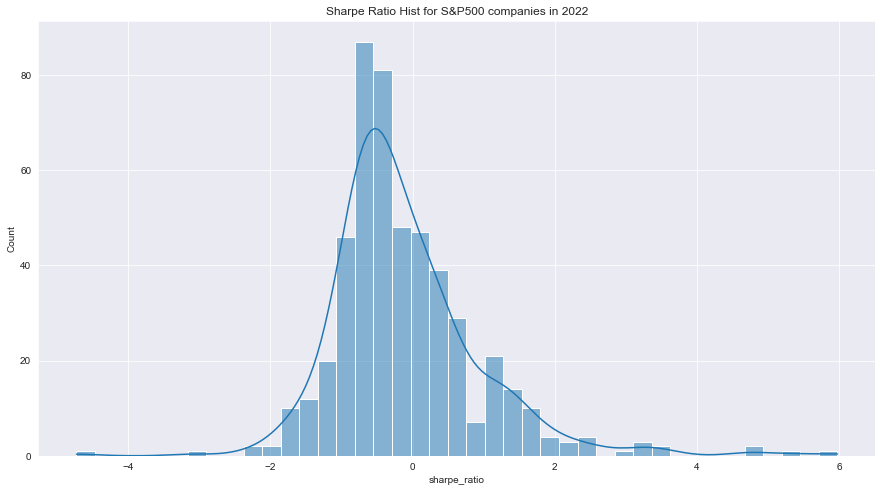

In [18]:
# Hists & KDEs
for year in range(date_begin_n,date_end_n+1):
    tmp_df = yearly_returns_stocks[yearly_returns_stocks['year']==year]
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,8))
    plt.title(f'Sharpe Ratio Hist for S&P500 companies in {year}')
    plt.rcParams.update({'font.size': 10})
    sns.histplot(x='sharpe_ratio',data=tmp_df, kde=True)

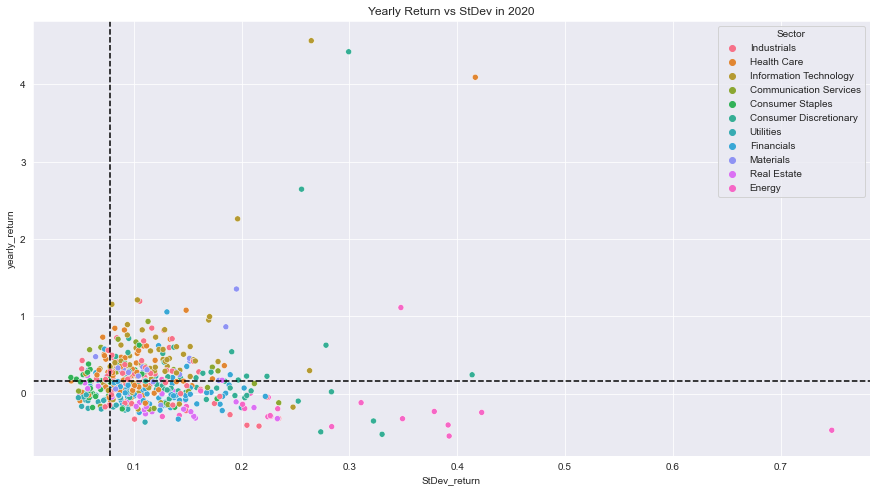

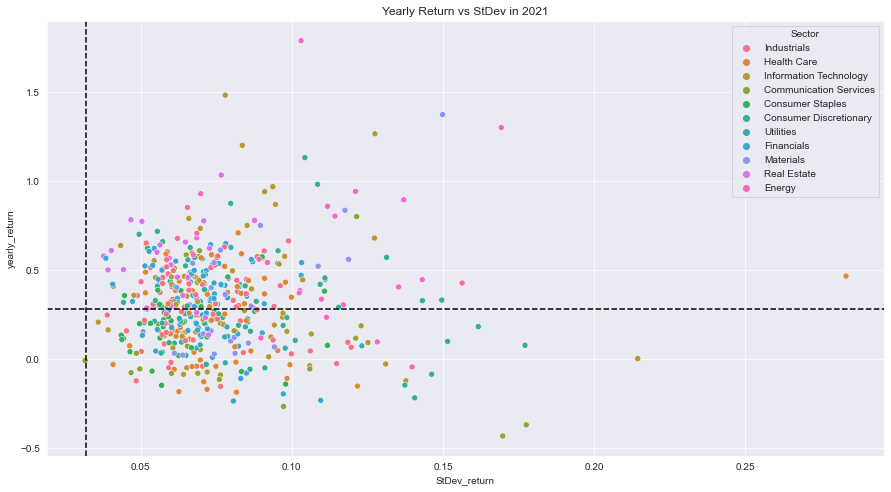

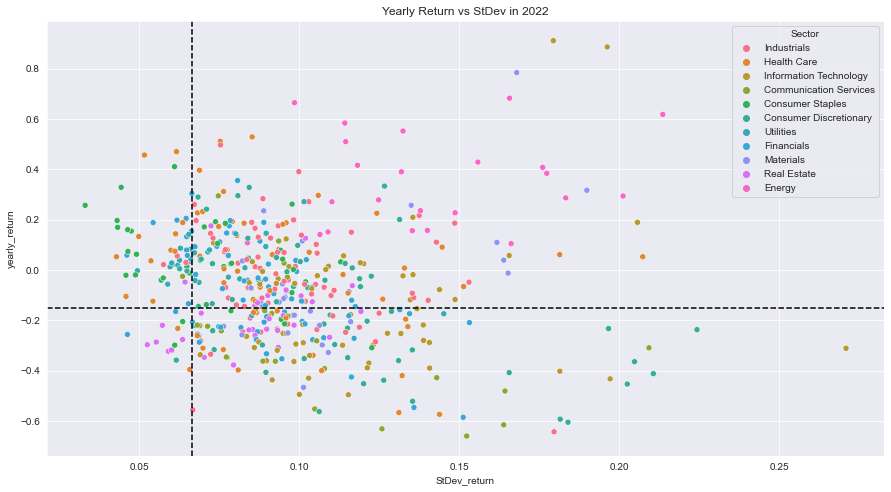

In [20]:
# ABCD Qudrant
for year in range(date_begin_n,date_end_n+1):
    tmp_df = yearly_returns_index.query(f'year == {year}').reset_index()
    value = tmp_df['yearly_return'][0]
    value_2 = tmp_df['StDev_return'][0]
    tmp_df = yearly_returns_stocks.query(f'year == {year}').reset_index()
    sns.set_style('darkgrid')
    plt.figure(figsize=(15,8))
    plt.title(f'Yearly Return vs StDev in {year}')
    plt.rcParams.update({'font.size': 10})
    plt.axhline(y=value, color='black', linestyle='--',ms=5)
    plt.axvline(x=value_2, color='black', linestyle='--',ms=5)
    sns.scatterplot(x='StDev_return',y='yearly_return',data=tmp_df, hue='Sector')